##Clipnorm

In [1]:
def scale_from_d(d):
    mean = 1.5
    # Calculate the z-score
    z_score = norm.ppf(1/d)

    # Calculate the standard deviation
    scale = - mean / z_score
    return scale

## Norm distribution

In [ ]:
import numpy as np
from scipy import integrate
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm.notebook import tqdm

# Define the normal distribution parameters
mean = 1.5
clipped = True
use_d_key = True

# Define the function sigma - sigma^2
def func(sigma, dist, shift):
    return dist * (sigma - shift) - (sigma - shift)**2
    #return sigma - sigma**2

def g_sigma(sigma, scale):
    return norm.pdf(sigma, mean, scale)  # Shifted by 0

# Define the integrand for each interval as the product of the function and the shifted pdf
def integrand1(sigma, lo, scale):
    return func(sigma, lo, 0) * g_sigma(sigma, scale)

def integrand2(sigma, lo, hi, scale):
    return func(sigma, (hi - lo), lo) * g_sigma(sigma, scale)

def integrand3(sigma, hi, scale):
    return func(sigma, (3 - hi), hi) * g_sigma(sigma, scale)

def expected_value_func(x, scale):
    lo = x[0]
    hi = x[1]


    total_weight = norm.cdf(3, mean, scale) - norm.cdf(0, mean, scale)
    if clipped:
        total_weight = 1

    # Calculate the weighted expected value by integrating the integrand over each range of sigma and summing
    expected_value = ((integrate.quad(integrand1, 0, lo, args=(lo, scale), limit=100)[0]) +
                      (integrate.quad(integrand2, lo, hi, args=(lo, hi, scale), limit=100)[0]) +
                      (integrate.quad(integrand3, hi, 3, args=(hi, scale), limit=100)[0])) / total_weight

    return expected_value

# Define the constraints with the fourth constraint
constraints_eq = ({'type': 'ineq', 'fun': lambda x:  x[0] - 0},  # lo > 0
                  {'type': 'ineq', 'fun': lambda x:  1.5 - x[0]})  # 1.5 > lo

los = []
# Loop over the desired scales
if use_d_key:
    scales = scale_from_d(np.arange(4, 2048))
else:
    scales = np.arange(0.01, 5.0, 0.001)

# Get the cumulative probabilities at 0 and 3
cdf_0 = norm.cdf(0, loc=mean, scale=scales[0])
cdf_3 = norm.cdf(3, loc=mean, scale=scales[0])

# Compute the adjusted percentiles
p33_adjusted = norm.ppf(cdf_0 + 0.33*(cdf_3 - cdf_0), loc=mean, scale=scales[0])
p67_adjusted = norm.ppf(cdf_0 + 0.67*(cdf_3 - cdf_0), loc=mean, scale=scales[0])
x0 = np.array([p33_adjusted, p67_adjusted])

for idx, scale in tqdm(enumerate(scales), total=len(scales)):
    # Optimize lo and hi for the current scale, first with the fourth constraint
    res = minimize(expected_value_func, x0, args=(scale), method='L-BFGS-B')
    uniform_res = expected_value_func([1.0, 2.0], scale)

    los.append(res.x[0])
    # Print the optimal lo and hi and the corresponding expected value
    print(f"{idx+4}: For scale {scale:.2f}, optimal lo = {res.x[0]:.3f}, hi = {(3 - res.x[0]):.3f}, expected value = {res.fun:.5f}, , non-opt value = {uniform_res:.5f}")

    x0 = res.x
    if res.x[0] < 1.01:
        break

In [3]:
norm_scales = scales
norm_los = los
ds = np.arange(4, 2048)

In [ ]:
len(ds)

2044

In [4]:
import pandas as pd

# After your loop
df = pd.DataFrame({
    'dim': ds,
    'norm_scales': norm_scales,
    'norm_los': norm_los,
    'clipped_scales': scales,
    'clipped_los': los,
})

df.to_csv('lo_data.csv', index=False)

In [5]:
scales = np.arange(4, 2048, dtype=float)

<ipython-input-6-13b5b4a6b304>:8: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(x * c) + d * x + f * x**0.5


Fitted function: lo = 0.95317444 + 0.03000649 * np.log(x * 1.98859949) + 0.00001230 * x + -0.00172387 * x**0.5
[ 9.53174444e-01  3.00064903e-02  1.98859949e+00  1.23002189e-05
 -1.72387142e-03]


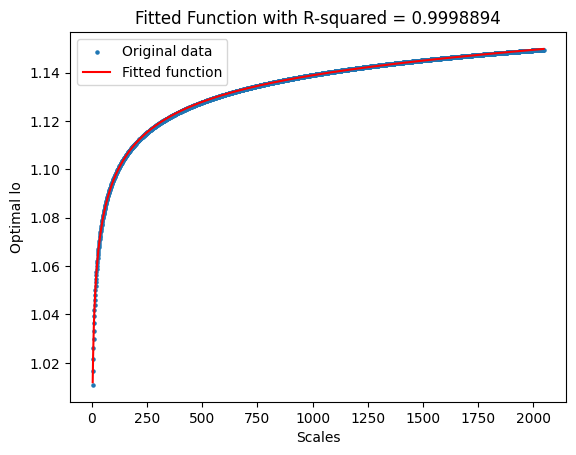

In [6]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# define the model function
def func(x, a, b, c, d, f):
    return a + b * np.log(x * c) + d * x + f * x**0.5

# Fit the model to the data
initial_guess = [1, 1, 1, 1, 1]  # Initial guess for the coefficients
popt, pcov = curve_fit(func, scales, los, p0=initial_guess)

# Build the string representation of the fitted function
func_str = f"Fitted function: lo = {popt[0]:.8f} + {popt[1]:.8f} * np.log(x * {popt[2]:.8f}) + {popt[3]:.8f} * x + {popt[4]:.8f} * x**0.5"
print(func_str)
print(popt)

# Compute predicted values from fitted function
y_pred = func(scales, *popt)

# Compute r-squared value
r2 = r2_score(los, y_pred)

# Plot original data
plt.scatter(scales, los, label='Original data', s=5)

# Plot fitted function
plt.plot(scales, y_pred, 'r', label='Fitted function')

plt.xlabel('Scales')
plt.ylabel('Optimal lo')
plt.legend()
plt.title(f'Fitted Function with R-squared = {r2:.7f}')
plt.show()
